Fitted parameters (a, b, rho, m, sigma): [ 0.00171877  0.15573239 -0.08820548  0.07132089  0.36902754]


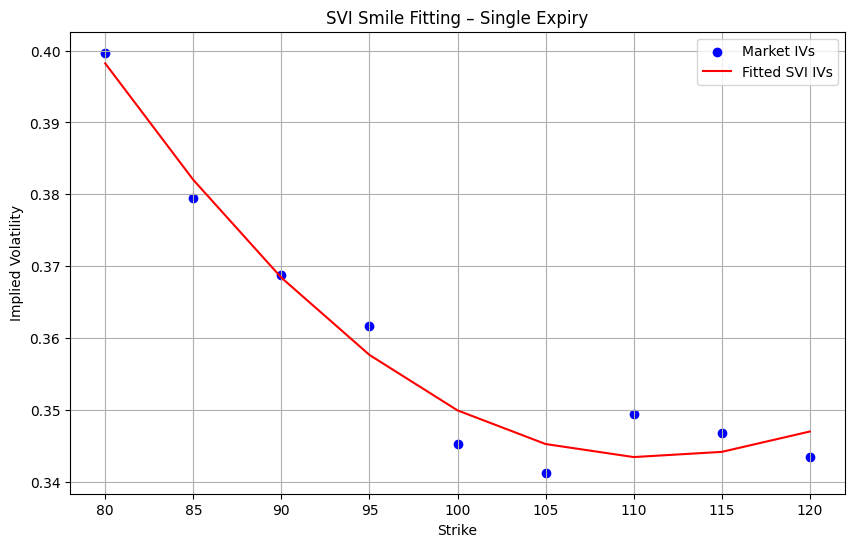

   Strike  LogMoneyness  Market_IV  Fitted_IV
0    80.0       -0.2231     0.3997     0.3982
1    85.0       -0.1625     0.3795     0.3820
2    90.0       -0.1054     0.3688     0.3684
3    95.0       -0.0513     0.3617     0.3577
4   100.0        0.0000     0.3452     0.3499
5   105.0        0.0488     0.3413     0.3453
6   110.0        0.0953     0.3495     0.3435
7   115.0        0.1398     0.3468     0.3442
8   120.0        0.1823     0.3434     0.3470


In [1]:
# Day 17 – SVI Smile Fitting

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ----------------------------
# Step 1: Create synthetic implied volatility smile data
# ----------------------------
np.random.seed(42)

# Synthetic strikes and mid-price IVs for one expiry
strikes = np.linspace(80, 120, 9)
fwd_price = 100  # forward price
log_moneyness = np.log(strikes / fwd_price)

# True parameters for SVI (a, b, rho, m, sigma)
true_params = [0.04, 0.1, -0.4, 0.0, 0.2]

def svi_total_variance(k, a, b, rho, m, sigma):
    return a + b * (rho * (k - m) + np.sqrt((k - m) ** 2 + sigma ** 2))

# Generate implied vols from total variance
total_variance = svi_total_variance(log_moneyness, *true_params)
T = 0.5  # 6 months to maturity
implied_vols = np.sqrt(total_variance / T)

# Add some noise to mimic market data
implied_vols += np.random.normal(0, 0.005, size=implied_vols.shape)

# ----------------------------
# Step 2: Fit SVI parameters
# ----------------------------
def objective(params, k, market_total_variance):
    a, b, rho, m, sigma = params
    model_w = svi_total_variance(k, a, b, rho, m, sigma)
    return np.sum((model_w - market_total_variance) ** 2)

market_total_variance = (implied_vols ** 2) * T

# Initial guess
x0 = [0.05, 0.05, 0.0, 0.0, 0.1]

# Bounds: keep them reasonable
bounds = [
    (0, 1),        # a
    (0, 1),        # b
    (-0.999, 0.999), # rho
    (-1, 1),       # m
    (0.001, 1)     # sigma
]

result = minimize(objective, x0, args=(log_moneyness, market_total_variance), bounds=bounds)

fitted_params = result.x
print("Fitted parameters (a, b, rho, m, sigma):", fitted_params)

# ----------------------------
# Step 3: Plot market vs fitted smile
# ----------------------------
fitted_total_variance = svi_total_variance(log_moneyness, *fitted_params)
fitted_vols = np.sqrt(fitted_total_variance / T)

plt.figure(figsize=(10, 6))
plt.scatter(strikes, implied_vols, color='blue', label='Market IVs')
plt.plot(strikes, fitted_vols, color='red', label='Fitted SVI IVs')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title('SVI Smile Fitting – Single Expiry')
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------
# Step 4: Summary DataFrame
# ----------------------------
df = pd.DataFrame({
    "Strike": strikes,
    "LogMoneyness": log_moneyness,
    "Market_IV": implied_vols,
    "Fitted_IV": fitted_vols
})
print(df.round(4))
